# Libraries

In [5]:
from mnist import MNIST
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.insert(0, '../../Libraries')
import JacksonsTSPackage as jts
from ltar import LTAR, LSTAR, LTARI, diff, invert_diff
from statsmodels.tsa.api import VAR

# Loading and Organizing the Data

In [6]:
mndata = MNIST('./Data')
images, labels = mndata.load_training()
labels = labels.tolist()

In [7]:
# Organizing the data
images = [x for _,x in sorted(zip(labels,images))]
labels.sort()
label_counts = list(Counter(labels).values())
num_cycles = min(label_counts)

tensor_shape = (num_cycles*10, 28, 28)
data = np.empty(tensor_shape)

# Makes the cycle
for i in range(num_cycles):
    for j in range(10):
        offset = sum(label_counts[:j]) + i
        tmp = np.asarray(images[offset])
        tmp.resize((tensor_shape[1], tensor_shape[2]))
        data[i*10 + j] = tmp

In [8]:
N = len(data)
N_train = N - 10
N_test = N - N_train
print(f"N: {N}")
print(f"N_train: {N_train}")
print(f"N_test: {N_test}")

N: 54210
N_train: 54200
N_test: 10


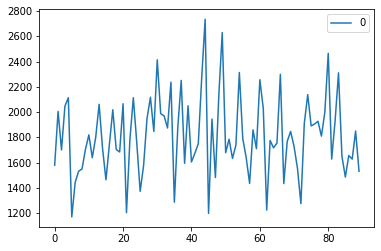

In [9]:
def plot_norm(tensor, N):
    norms = []
    for i in range(N):
        norms.append(np.linalg.norm(tensor[i], ord="fro"))
    pd.DataFrame(norms).plot()
    plt.show()
plot_norm(data[:100], 90)

In [10]:
fig, axs = plt.subplots(ncols=20, gridspec_kw={"wspace":0, "hspace":0})
for i in range(20):
    axs[i].imshow(data[i], cmap='gray')
    axs[i].axis('off')

In [6]:
train_tensor = jts.extract_train_tensor(data, N_train)
train_tensor

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

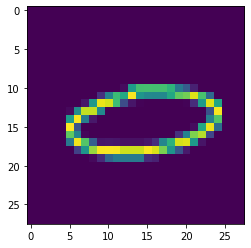

In [7]:
plt.imshow(train_tensor[0])

In [8]:
test_tensor = jts.extract_test_tensor(data, N_train, N_test)
test_tensor

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [9]:
ltar = LSTAR(train_tensor)
ltar.fit(10, 10, "dct")

In [10]:
result_tensor = ltar.forecast(N_test)

<AxesSubplot:>

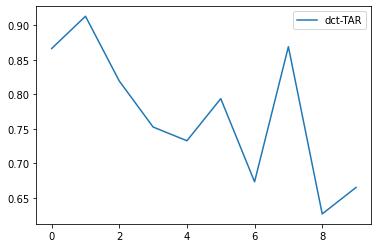

In [15]:
dct_error = jts.calc_mape_per_matrix(test_tensor, result_tensor)
dct_error = dct_error.rename(columns={"MAPE": "dct-TAR"})
dct_error.plot()

In [16]:
dct_error

,dct-TAR
0,0.86647
1,0.913258
2,0.819302
3,0.75265
4,0.732788
5,0.793802
6,0.673309
7,0.869126
8,0.626718
9,0.665092
